<a href="https://colab.research.google.com/github/sameerchauhan360/deep-learning/blob/main/Transfer_Learning_Cat_vs_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten

# importing the data from kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:04<00:00, 261MB/s]
100% 1.06G/1.06G [00:04<00:00, 269MB/s]


# Extracting the Zip File

In [5]:
from zipfile import ZipFile

In [6]:
zip_ref = ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall()
zip_ref.close()

# Loading the Xception Model

## Importing

In [7]:
from keras.applications.xception import Xception

## Extracting the convolutional part

83683744/83683744 [==============================] - 0s 0us/step


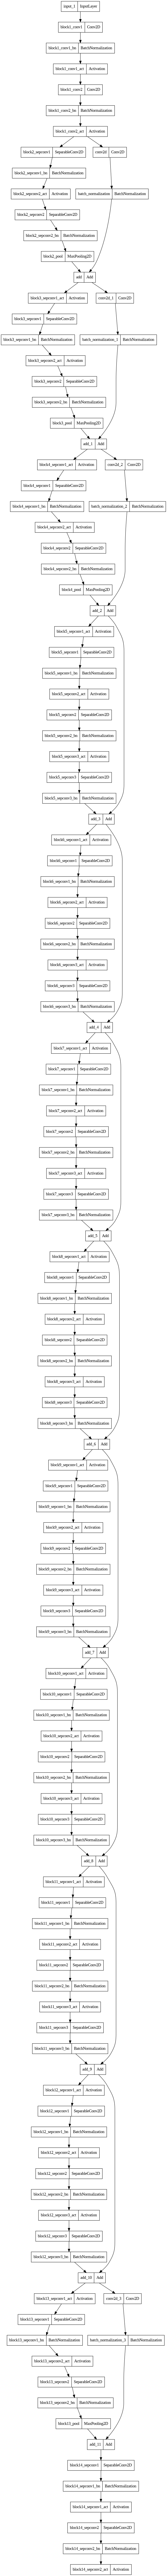

In [8]:
conv_base = Xception(
    weights = 'imagenet',
    include_top = False, # Fully Connected Layer
    input_shape = (150, 150,3)
)

keras.utils.plot_model(conv_base)

## Creating the model

In [9]:
model = Sequential([
    conv_base,

    Flatten(),

    Dense(128, activation='relu'),
    Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27415337 (104.58 MB)
Trainable params: 27360809 (104.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


## make Xception model part Non Trainable

In [10]:
conv_base.trainable = False

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27415337 (104.58 MB)
Trainable params: 6553857 (25.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


# loading the data from directory

In [12]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size=32,
    image_size = (150, 150)
)
val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


## normalizing the data

In [13]:
def process(image, label):

  image = tf.cast(image / 255, tf.float32)
  return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [18]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img

## Data Augmentation

In [23]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40
)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [25]:
train_generator = train_datagen.flow_from_directory(
    directory='/content/train',
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = test_datagen.flow_from_directory(
    directory = '/content/test',
    target_size=(150,150),
    batch_size=32,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Compile Model

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# training with augmented data

In [29]:
history1 = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator)

<ipython-input-29-cf21e39efdf1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
625/625 [==============================] - 159s 250ms/step - loss: 0.1481 - accuracy: 0.9428 - val_loss: 0.0889 - val_accuracy: 0.9652
Epoch 2/10
625/625 [==============================] - 152s 244ms/step - loss: 0.1268 - accuracy: 0.9492 - val_loss: 0.0857 - val_accuracy: 0.9652
Epoch 3/10
625/625 [==============================] - 152s 243ms/step - loss: 0.1219 - accuracy: 0.9501 - val_loss: 0.0816 - val_accuracy: 0.9656
Epoch 4/10
625/625 [==============================] - 153s 245ms/step - loss: 0.1198 - accuracy: 0.9532 - val_loss: 0.0912 - val_accuracy: 0.9640
Epoch 5/10
625/625 [==============================] - 153s 244ms/step - loss: 0.1094 - accuracy: 0.9553 - val_loss: 0.0898 - val_accuracy: 0.9658
Epoch 6/10
625/625 [==============================] - 152s 243ms/step - loss: 0.1092 - accuracy: 0.9559 - val_loss: 0.0899 - val_accuracy: 0.9624
Epoch 7/10
625/625 [==============================] - 151s 242ms/step - loss: 0.1129 - accuracy: 0.9544 - val_loss: 0.0870 -

# training without augmented data

In [15]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
625/625 [==============================] - 58s 78ms/step - loss: 0.2615 - accuracy: 0.9560 - val_loss: 0.0810 - val_accuracy: 0.9680
Epoch 2/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0640 - accuracy: 0.9756 - val_loss: 0.0875 - val_accuracy: 0.9652
Epoch 3/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0487 - accuracy: 0.9812 - val_loss: 0.1000 - val_accuracy: 0.9626
Epoch 4/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0395 - accuracy: 0.9854 - val_loss: 0.1115 - val_accuracy: 0.9624
Epoch 5/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0373 - accuracy: 0.9866 - val_loss: 0.1127 - val_accuracy: 0.9642
Epoch 6/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0422 - accuracy: 0.9848 - val_loss: 0.1214 - val_accuracy: 0.9664
Epoch 7/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0243 - accuracy: 0.9905 - val_loss: 0.1603 - val_accuracy:

# analysing the perfomance

In [16]:
import matplotlib.pyplot as plt


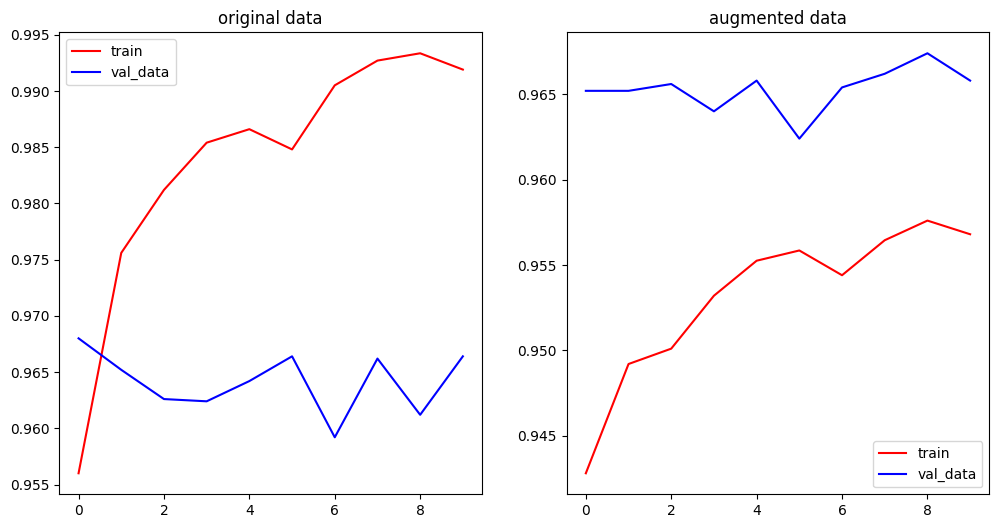

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.plot(history.history['accuracy'], color='red', label='train')
ax1.plot(history.history['val_accuracy'], color = 'blue', label='val_data')
ax1.set_title('original data')
ax1.legend()

ax2.plot(history1.history['accuracy'], color='red', label='train')
ax2.plot(history1.history['val_accuracy'], color = 'blue', label='val_data')
ax2.set_title('augmented data')
ax2.legend()

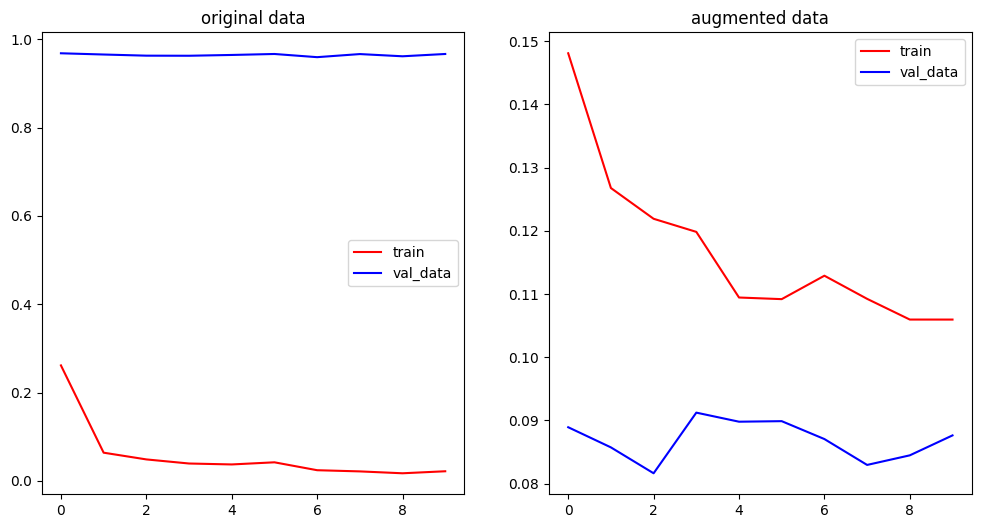

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.plot(history.history['loss'], color='red', label='train')
ax1.plot(history.history['val_accuracy'], color = 'blue', label='val_data')
ax1.set_title('original data')
ax1.legend()

ax2.plot(history1.history['loss'], color='red', label='train')
ax2.plot(history1.history['val_loss'], color = 'blue', label='val_data')
ax2.set_title('augmented data')
ax2.legend()